# Transport network density

## Introduction

This notebook is based on the [eu_grid_population.py](https://github.com/GISAdamToth/characteristics_of_transport_network_toolbox/blob/main/python_scripts/eu_grid_population.py) script, which is part of the [Calculation possibilies of transport network's characteristics of countries and cities](https://www.geoinformatics.upol.cz/dprace/bakalarske/toth22/) bachelor thesis by Adam Tóth (2022).

In this notebook you will calculate the transport network density in two ways:
1) "classic" approach, where density = length / area
2) "demographic" approach, where density = length / population

You'll need a cloned ArcGIS Python environment so you can run [**ArcPy**](https://pro.arcgis.com/en/pro-app/3.1/arcpy/get-started/what-is-arcpy-.htm) functions and install additional packages. This notebook was tested for ArcGIS Pro 3.0.2 using cloned Python 3.9.18 environment. 5 extra libraries were installed into this environment: [**Folium**](https://python-visualization.github.io/folium/latest/index.html), [**OSMnx**](https://osmnx.readthedocs.io/en/stable/), [**GeoPandas**](https://geopandas.org/en/stable/), [**Requests**](https://pypi.org/project/requests/) and [**zipfile**](https://docs.python.org/3/library/zipfile.html). You can install them using Package manager in the ArcGIS Pro Project tab or using Python Command Prompt and running this command: ```pip install package_name```.

The workflow is divided into the following sections:
- [ArcGIS setup](#arcgis)
- [Transport network data](#osmnx)
- [Population data](#popgrid)
- [Hexagonal grid](#hex)
- [Density calculation](#calc)
- [Visualization](#vis)

## ArcGIS setup <a id="arcgis"></a>

Start ArcGIS Pro, create a new project and add this notebook into it if you haven't already done it. You can use and run this notebook outside of ArcGIS Pro project as well, but when you'll be running geoprocessing tools via **ArcPy**, you can see the results immediately in the project's map.

Import **ArcPy** and allow overwriting outputs with the same name.

In [1]:
import arcpy
arcpy.env.overwriteOutput = True

Save the path to your project's folder into the variable ```workspace_dir```. Do the same for the path to your project's geodatabase, just change the variable name and set it as the workspace.

In [2]:
workspace_dir = "D:/transport_netw_char/"
workspace_gdb = workspace_dir + "transport_netw_char.gdb/"
arcpy.env.workspace = workspace_gdb

## Transport network data <a id="osmnx"></a>

Transport network is a term which covers all parts of the transport infrastructure in a certain area, typically country, region or city. Transport network therefore includes roads, railways, airports, river and sea ports (harbours), pipelines, all kinds of junctions, terminals and so on. This notebook focuses on the line features of transport network, because the density is expressed as **length** either per area or per capita. 

Therefore you can use any kind of line layer representing highways, streets, railways for example. In this part you'll go through the process of accessing railways data from OpenStreetMap (OSM) and getting them ready for further work in ArcGIS Pro.

This part is inspired by the notebook [Accessing OSM Data in Python](https://pygis.io/docs/d_access_osm.html) published at PyGIS.

Import **folium**, **OSMnx** and **GeoPandas** packages now.

In [3]:
import folium
import osmnx as ox
import geopandas as gpd

### Area of interest

The first step is to choose the area of interest. You can choose any European city, region or country. For this notebook the area of interest will be the Liverpool city in the UK.

In [4]:
place_name = "Liverpool, UK"

Using the [**geocode_to_gdf**](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.geocoder.geocode_to_gdf) function from **OSMnx** package, save the area of interest as a GeoDataFrame into the variable ```area``` and check how is looks like.

In [10]:
area = ox.geocode_to_gdf(place_name)
area

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((-3.01917 53.43616, -3.01806 53.43323...",53.474989,53.311543,-2.818,-3.019173,250026126,relation,172987,53.407199,-2.99168,boundary,administrative,16,0.670751,city,Liverpool,"Liverpool, Liverpool City Region, England, Uni..."


You can also verify its data type and print its coordinates.

In [ ]:
print(type(area))
print(f"latitude: {area.lat.values[0]}, longitude: {area.lon.values[0]}")

Now create a simple map using **folium** centered to Liverpool and add the ```area``` GeoDataFrame into it.

In [12]:
m = folium.Map([area.lat.values[0], area.lon.values[0]], zoom_start=11, tiles="cartodbpositron", control_scale=True)

# area
folium.GeoJson(
    area,
    name = "Liverpool boundary", 
    style_function = lambda feature: {
        "fillColor": "#f5b30c",
        "color": "orange",
        "weight": 1
    }
).add_to(m)

# menu in the top right corner where you can turn on and off the map layers
folium.LayerControl().add_to(m)
# display the map
m

Define variable ```area_name``` and set its value to ```'liverpool_boundary'```. Save now the ```area``` as a geojson file into the folder with your project.

In [13]:
area_name = 'liverpool_boundary'
area.to_file(workspace_dir + area_name + '.geojson', driver='GeoJSON')

Import the geojson file with your area of interest into your geodatabase if it's not already there. Use the [**JSON To Features**](https://pro.arcgis.com/en/pro-app/latest/tool-reference/conversion/json-to-features.htm) tool.

In [ ]:
if arcpy.Exists(area_name):
    print(f"{area_name}.geojson already exists in {workspace_gdb}")
else:
    arcpy.conversion.JSONToFeatures(workspace_dir + area_name + '.geojson', area_name, "POLYGON")
    print(f"{area_name}.geojson successfully imported into {workspace_gdb}")

### OSM data

Let's now get to the OSM railway data. OSM data is divided into multiple categories and these are divided into several subcategories. You can choose which category you are interested in by specifying its name from the list of [OSM tags](https://wiki.openstreetmap.org/wiki/Map_features).

If you want to get to all subcategories of the chosen category, type ```True```.

Now get all kinds of railways in Liverpool into the GeoDataFrame ```railways```.

In [15]:
# get all types of railways (https://wiki.openstreetmap.org/wiki/Map_features#Railway)
tags = {'railway': True}  
# get only rails = "Full sized passenger or freight train tracks in the standard gauge for the country or state." 
#tags = {'railway': 'rail'}  

railways = ox.features_from_place(place_name, tags)
railways.head()

railway                   geometry  ... ways type
element_type osmid                                         ...          
node         24817480   switch  POINT (-2.88837 53.35797)  ...  NaN  NaN
             24817497   switch  POINT (-2.86186 53.35360)  ...  NaN  NaN
             24825496     stop  POINT (-2.94467 53.40238)  ...  NaN  NaN
             24825515  station  POINT (-2.92282 53.40522)  ...  NaN  NaN
             25296243     stop  POINT (-2.88881 53.35825)  ...  NaN  NaN

[5 rows x 108 columns]

Print the number of ```railways```.

In [ ]:
print(len(railways))

Keep only the geometry attribute of the ```railways``` because that's what you are interested in.

In [17]:
railways = railways.loc[:,railways.columns.str.contains('addr:|geometry')]

And select only those rows that are of a LineString geometry type. Then print the number of these ```railways```.

In [ ]:
railways = railways.loc[railways.geometry.type=='LineString']
print(len(railways))

Now add the ```railways``` into the **folium** map together with the ```area```.

In [19]:
m = folium.Map([area.lat.values[0], area.lon.values[0]], zoom_start=11, tiles="cartodbpositron", control_scale=True)

# area
folium.GeoJson(
    area,
    name = "Liverpool boundary", 
    style_function = lambda feature: {
        "fillColor": "#f5b30c",
        "color": "orange",
        "weight": 1
    }
).add_to(m)

# railways
folium.GeoJson(
    railways,
    name = "Liverpool rails",
    style_function = lambda feature: {
        "color": "black",
        "weight": 1
    }
).add_to(m)

# menu in the top right corner where you can turn on and off the map layers
folium.LayerControl().add_to(m)
# display the map
m

Define variable ```rails``` and set its value to ```'liverpool_rails'```. Save now the ```railways``` as a geojson file into the folder with your project.

In [20]:
rails = 'liverpool_rails'
railways.to_file(workspace_dir + rails + '.geojson', driver='GeoJSON')

Import the geojson file with railways into your geodatabase if it's not already there. Use the [**JSON To Features**](https://pro.arcgis.com/en/pro-app/latest/tool-reference/conversion/json-to-features.htm) tool.

In [ ]:
if arcpy.Exists(rails):
    print(f"{rails}.geojson already exists in {workspace_gdb}")
else:
    arcpy.conversion.JSONToFeatures(workspace_dir + rails + '.geojson', rails, "POLYLINE")
    print(f"{rails}.geojson successfully imported into {workspace_gdb}")

## Population data <a id="popgrid"></a>

In this part you'll download GEOSTAT 1 $km^2$ population grid. It is a population dataset provided by Eurostat which covers the most of Europe. It consists of 1 $km^2$ squares and each square contains the number of inhabitants who live inside the square area.

Import **os**, **requests** and **zipfile** packages.

In [22]:
import os
import requests
import zipfile

Set parameters and variables for downloading zipped population grid from the eurostat website.

In [23]:
# URL of the population grid to download
url = "https://ec.europa.eu/eurostat/cache/GISCO/geodatafiles/JRC_GRID_2018.zip"

# it's gonna be downloaded in zipped file
file_name = "JRC_GRID_2018.zip"
file_path = os.path.join(workspace_dir, file_name)  # save in the workspace directory

Send a GET request to the URL to download the population grid, but only if it's not already downloaded.

In [24]:
if arcpy.Exists(file_path):
    print(f"You have already downloaded {file_name}.")
else:
    response = requests.get(url)
    
    # check if the request was successful (status code 200)
    if response.status_code == 200:
        # write the content to a file
        with open(file_path, 'wb') as f:
            f.write(response.content)
        print(f"File '{file_name}' downloaded successfully!")
    else:
        print("Failed to download the file.")

You have already downloaded JRC_GRID_2018.zip.


Save the path to the population grid shapefile about to be extracted in the variable ```pop_data```.

In [ ]:
pop_data = file_path[:-4] + '/JRC_POPULATION_2018.shp'
pop_data

Extract (unzip) now the downloaded folder, but again only if it hasn't been already extracted.

In [ ]:
if arcpy.Exists(pop_data):
    print("Downloaded and zipped population grid has already been extracted.")
else:
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(file_path[:-4] + '/')
    print("Population grid successfully extracted.")

Here's a simple visualization of this population grid.

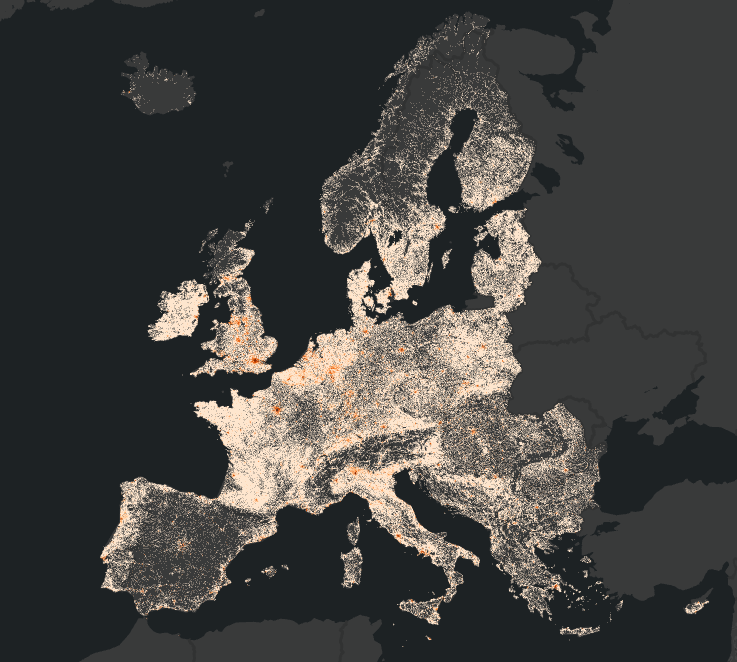

### Population grid editing

Now you need to clip the population grid by the area of interest. This step is not that simple as it looks, because some of the grid's squares or "pixels" will be cut during clipping, so they will became smaller. But the number of inhabitants will remain the same. Therefore the population inside of the pixels has to be recalculated proportionally to the actual "pixel" size.

First [**select**](https://pro.arcgis.com/en/pro-app/3.1/tool-reference/data-management/select-layer-by-location.htm) the population grid "pixels" that intersect with the area of interest. Copy (tool [**Copy Features**](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/copy-features.htm)) these "pixels" into your workspace.

In [ ]:
population_in_area = "pop_data_liverpool"

if arcpy.Exists(population_in_area):
    print(f"Copied population grid that intersects with {area_name} already exists in {workspace_gdb}.")
else:
    area_selection = arcpy.management.SelectLayerByLocation(pop_data, "INTERSECT", area_name)
    arcpy.management.CopyFeatures(area_selection, population_in_area)
    area_selection = arcpy.management.SelectLayerByAttribute(pop_data, "CLEAR_SELECTION")
    print(f"Population grid that intersects with {area_name} was successfully copied into {workspace_gdb}.")

At this point you are starting to work in ArcGIS Pro with feature classes and geoprocessing tools. It is necessary to unite the coordinate system of all outputs in order to get to correct and valid results. Let's choose the coordinate system of population grid, which is ETRS 1989 LAEA. It has several advantages including meter as the linear unit and suitability for the whole European territory.

There are multiple ways how to achieve this, perhaps the easiest one is to get the coordinate system by accessing layer's [spatial reference](https://pro.arcgis.com/en/pro-app/latest/arcpy/classes/spatialreference.htm) and then setting it as the [environment output coordinate system](https://pro.arcgis.com/en/pro-app/3.1/tool-reference/environment-settings/output-coordinate-system.htm).

In [28]:
pop_grid_spref = arcpy.Describe(population_in_area).spatialReference
arcpy.env.outputCoordinateSystem = pop_grid_spref
arcpy.env.outputCoordinateSystem

name (Projected Coordinate System),ETRS_1989_LAEA
factoryCode (WKID),3035
linearUnitName (Linear Unit),Meter
name (Geographic Coordinate System),GCS_ETRS_1989
factoryCode (WKID),4258
angularUnitName (Angular Unit),Degree
datumName (Datum),D_ETRS_1989


Save the "pixel" area size in a new field which will be named ```"area_orig"```. You will make a copy of the ```"Shape_Area"``` field basically. Tools [**Add**](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/add-field.htm) and [**Calculate**](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/calculate-field.htm) field are useful.

In [ ]:
fields = arcpy.ListFields(population_in_area, "area_orig", "Double")   #ListFields() reference: https://pro.arcgis.com/en/pro-app/latest/arcpy/functions/listfields.htm

if len(fields)>0:
    print(f"Field of type Double and named 'area_orig' is already present in layer {population_in_area}.")
else:
    arcpy.management.AddField(population_in_area, "area_orig", "DOUBLE")
    print(f"New field of type Double named 'area_orig' was successfully added into layer {population_in_area}.")

This **CalculateField** function in the next cell only works when run in Notebook in ArcGIS Pro. When it's run in Visual Studio Code, it gives this error: *ERROR 000574: Python is not installed. Failed to execute (CalculateField).*

In [ ]:
arcpy.management.CalculateField(population_in_area, "area_orig", '!Shape_Area!')

[**Clip**](https://pro.arcgis.com/en/pro-app/3.1/tool-reference/analysis/clip.htm) the copied population grid "pixels" by the area of interest.

In [ ]:
pop_data = "pop_data_clip"

if arcpy.Exists(pop_data):
    print(f"Clipped population grid already exists in {workspace_gdb}.")
else:
    arcpy.analysis.Clip(population_in_area, area_name, pop_data)
    print("Population grid was successfully clipped.")

Add a new field named ```"P_2018_orig"``` and recalculate the population in the clipped "pixels" proportionally to their area size into it.

In [ ]:
fields = arcpy.ListFields(pop_data, "P_2018_orig", "Double")   

if len(fields)>0:
    print(f"Field of type Double and named 'P_2018_orig' is already present in layer {pop_data}.")
else:
    arcpy.management.AddField(pop_data, "P_2018_orig", 
                              "DOUBLE")
    print(f"New field of type Double named 'P_2018_orig' was successfully added into layer {pop_data}.")

Again, run this cell in ArcGIS Pro, or if you want to keep working with this notebook outside of ArcGIS Pro, comment this next code line and calculate the field manually in ArcGIS Pro and then continue running cells in this notebook.

In [ ]:
arcpy.management.CalculateField(pop_data, "P_2018_orig", 
                '(!TOT_P_2018!/!area_orig!)*!Shape_Area!')

## Hexagonal grid <a id="hex"></a>

[**Generate**](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/generatetesellation.htm) a hexagonal grid of hexagon size 2 $km^2$ over the area of interest. Railways density will be calculated for each hexagon.

In [34]:
size = "2 SquareKilometers"
    
if arcpy.Exists("hex_grid_regular"):
    print(f"Hexagonal grid already exists in {workspace_gdb}")
else:
    arcpy.management.GenerateTessellation("hex_grid_regular", area_name, "HEXAGON", size)

Clip the hexagonal grid by the ```area_name``` layer.

In [35]:
if arcpy.Exists("hex_gr"):
    print(f"Hexagonal grid clipped by {area_name} already exists in {workspace_gdb}")
else:
    arcpy.analysis.Clip("hex_grid_regular", area_name, "hex_gr")

Now you'll do the same population recalculation as you did during clipping, but now the "pixels" will be intersected and dissolved. Here is an illustration of the population recalculation.

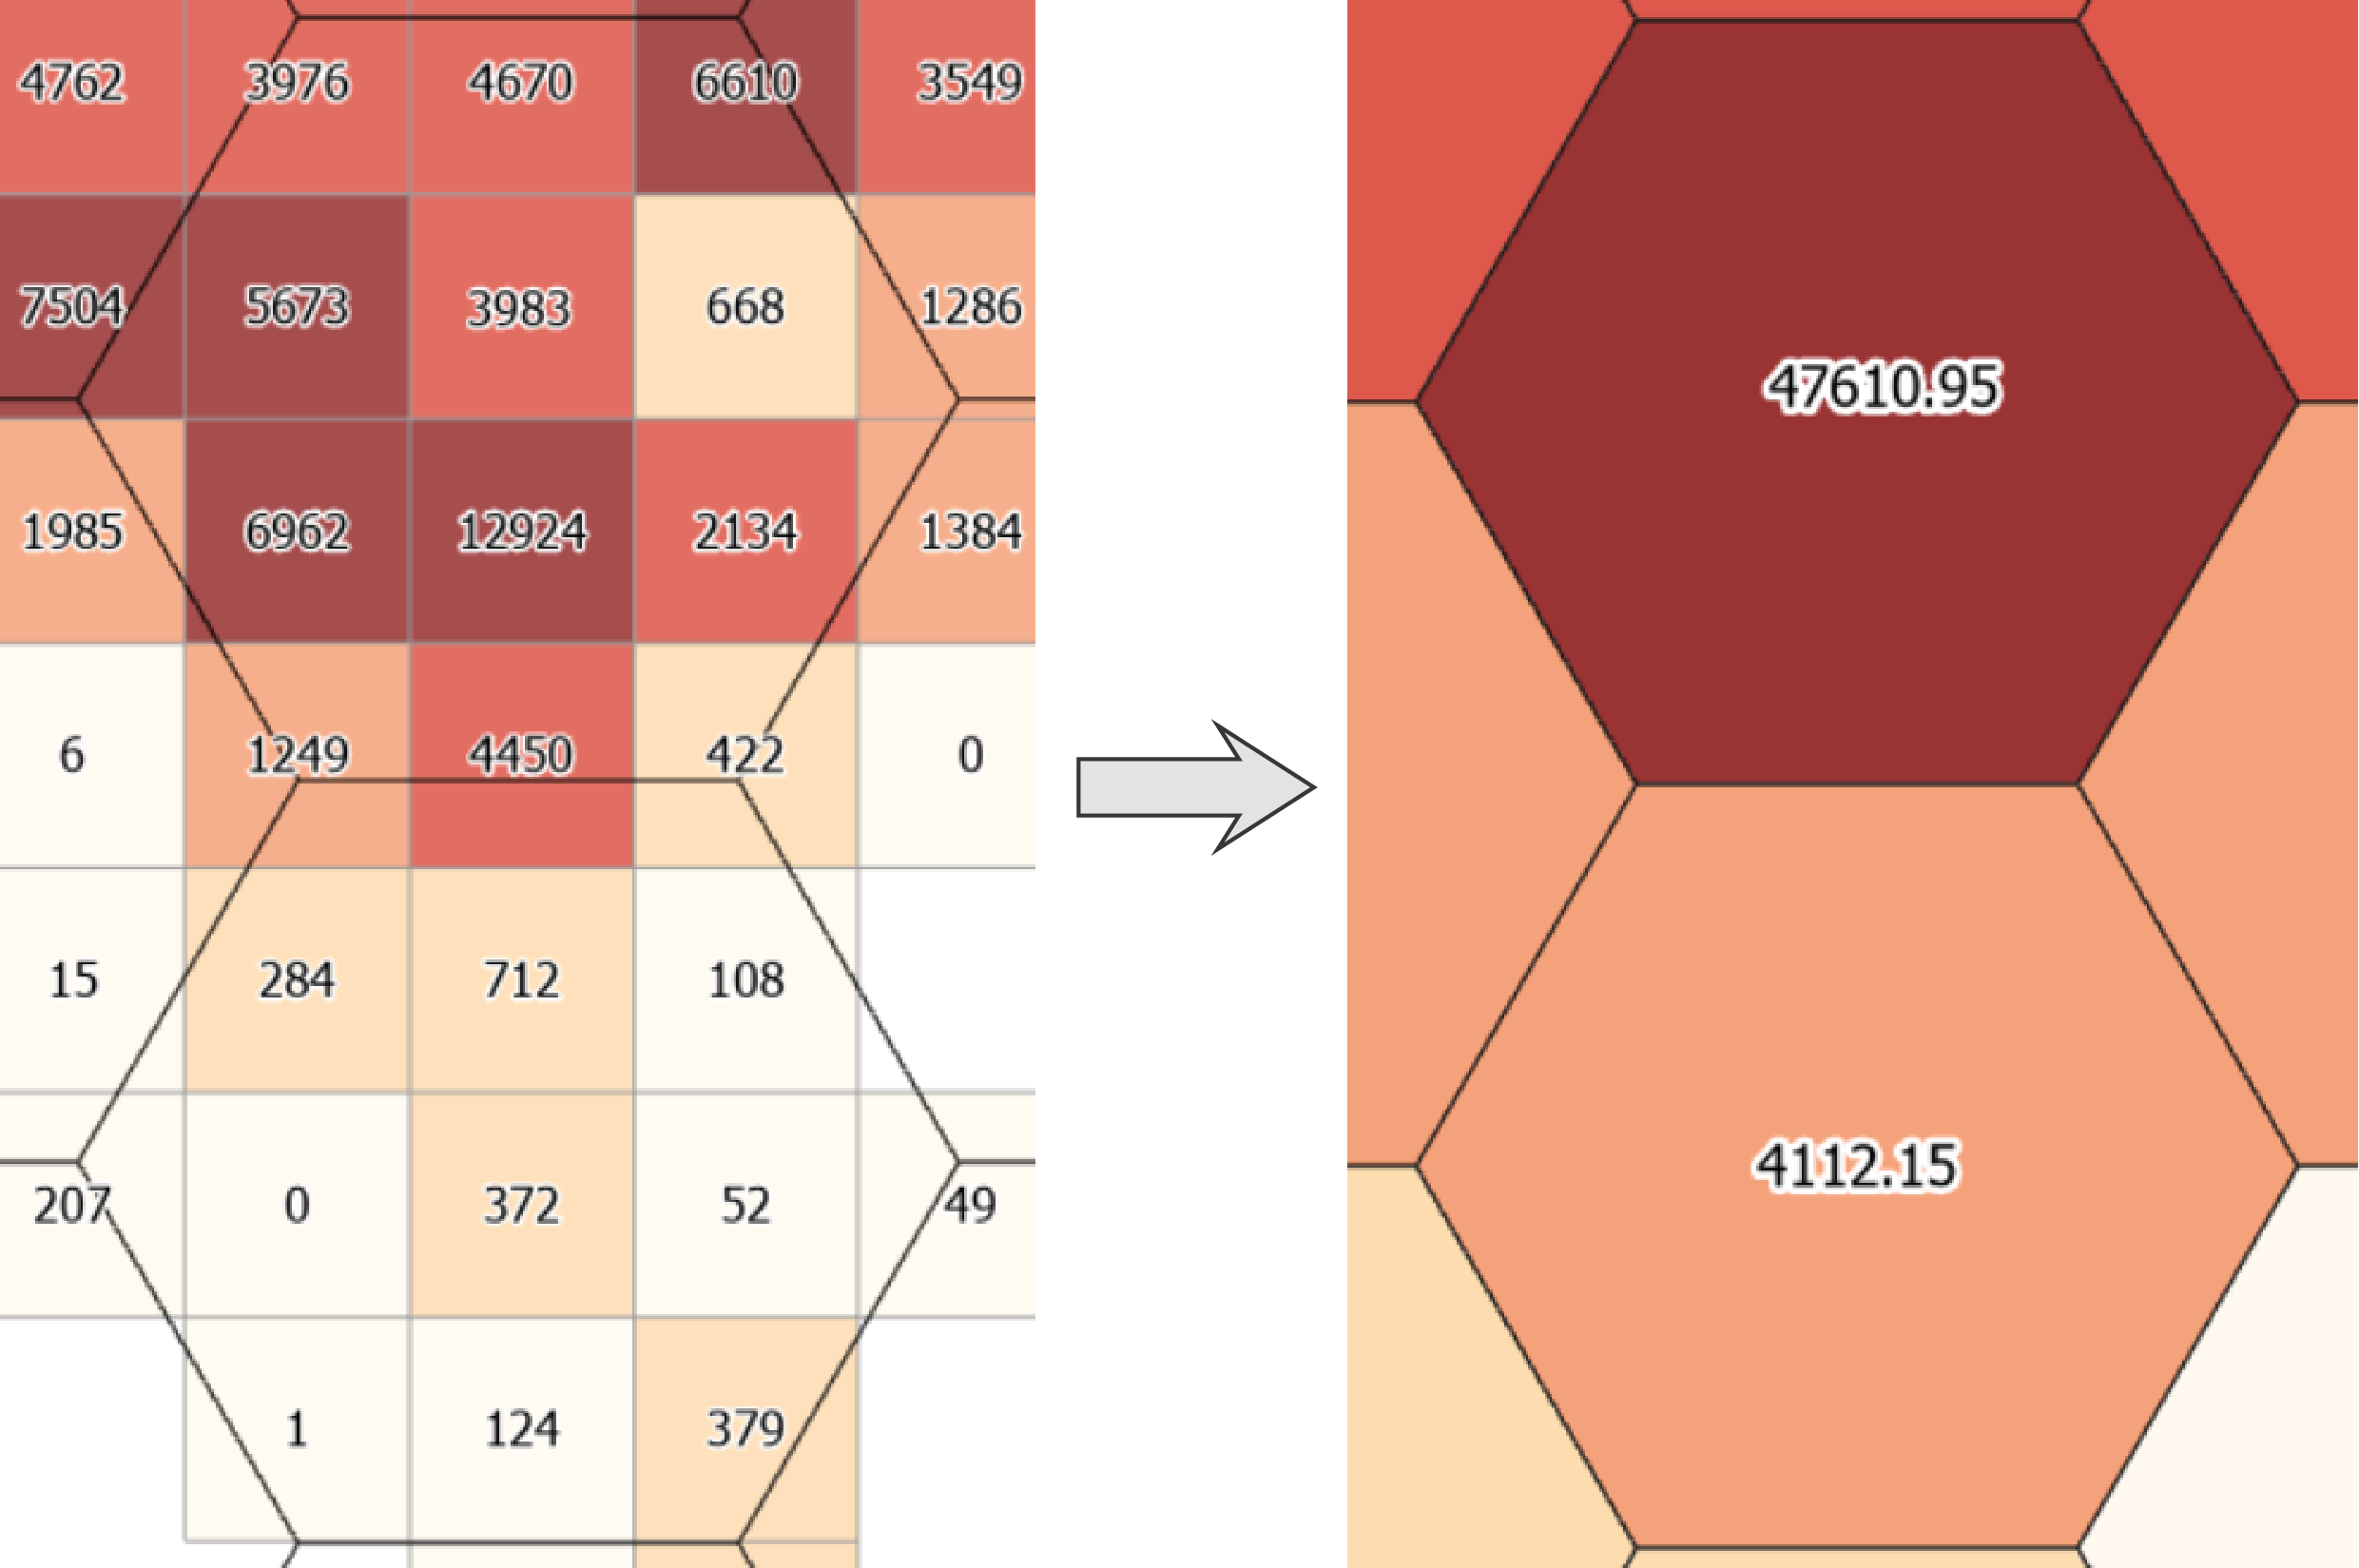

Field ```"area_orig"``` will contain the area size of current clipped "pixels".

In [ ]:
arcpy.management.CalculateField(pop_data, "area_orig", '!Shape_Area!')

Now you'll get the population information into the hexagons. [**Intersect**](https://pro.arcgis.com/en/pro-app/latest/tool-reference/analysis/intersect.htm) first the population grid by the hexagonal grid.

In [37]:
if arcpy.Exists("pop_data_isect"):
    print("Population grid was already intersected by hexagons.")
else:    
    arcpy.analysis.Intersect([pop_data, "hex_gr"], "pop_data_isect", "ALL")

Add field named ```"new_pop2018"``` into the intersected population grid's attribute table and calculate there population size using the same principle as it was used when calculating population after clipping.

In [ ]:
fields = arcpy.ListFields("pop_data_isect", "new_pop2018", "Double")

if len(fields) > 0:
    print("Field of type Double and named 'new_pop2018' is already present in layer 'pop_data_isect'.")
else:
    arcpy.management.AddField("pop_data_isect", "new_pop2018", "DOUBLE")
    print("New field of type Double named 'new_pop2018' was successfully added into layer 'pop_data_isect'.")

In [ ]:
arcpy.management.CalculateField("pop_data_isect", "new_pop2018", '(!P_2018_orig!/!area_orig!)*!Shape_Area!')

[**Dissolve**](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/dissolve.htm) the population grid's "pixels" by hexagon's ID while summing the ```"new_pop2018"``` field and then [**join**](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/join-field.htm) this field to the ```"hex_gr"``` layer.

In [42]:
if arcpy.Exists("pop_data_isect_diss"):
    print("Population grid intersected by hexagonal grid was already dissolved.")
else:
    arcpy.management.Dissolve("pop_data_isect", "pop_data_isect_diss", "FID_hex_gr", [["new_pop2018","SUM"]])

fields = arcpy.ListFields("hex_gr", "SUM_new_pop2018", "Double")
if len(fields) > 0:
    print("The 'SUM_new_pop2018' field has already been joined to the 'hex_gr' layer.")
else:
    arcpy.management.JoinField("hex_gr", "OBJECTID", "pop_data_isect_diss", "FID_hex_gr", ["SUM_new_pop2018"])

Some hexagons don't have any population, because the population grid doesn't cover the whole area, only municipalities where people live. Therefore you need to [**select**](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/select-layer-by-attribute.htm) those hexagons with null values in the ```"SUM_new_pop_2018"``` field and instead of null write ```0.0```. Otherwise it would cause problems during density calculation.

In [ ]:
no_people = arcpy.management.SelectLayerByAttribute("hex_gr", "NEW_SELECTION", "SUM_new_pop2018 IS NULL")
if int(no_people[1]) > 0:
    arcpy.management.CalculateField(no_people, "SUM_new_pop2018", '0.0')
arcpy.management.SelectLayerByAttribute("hex_gr", "CLEAR_SELECTION")

Now you'll get the information about the rails length into the hexagonal grid. It'll be similar process to the one you just did with the population grid. 

First [**project**](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/project.htm) the rails into the same coordinate system as the environment output coordinate system.

In [44]:
arcpy.management.Project(rails, "liverpool_rails_proj", pop_grid_spref)
rails_proj = "liverpool_rails_proj"

**Intersect** the rails with hexagonal grid and then **dissolve** them by hexagon's ID.

In [ ]:
if arcpy.Exists("rl_isect"):
    print("Projected rails has already been intersected.")
else:    
    arcpy.analysis.Intersect([rails_proj, "hex_gr"], "rl_isect", "ONLY_FID")

if arcpy.Exists("rl_isect_diss"):
    print("Intersected rails has already been dissolved.")
else:  
    arcpy.management.Dissolve("rl_isect", "rl_isect_diss", "FID_hex_gr")

Save the rails length in each hexagon by creating new field named ```"rl_length"``` and populating it with the values from the ```"Shape_Length"``` field. **Join** this information to the ```"hex_gr"``` layer.

In [46]:
fields = arcpy.ListFields("rl_isect_diss", "rl_length", "Double")
if len(fields) > 0:
    print("The 'rl_length' field has already been created in the 'rl_isect_diss' layer.")
else:
    arcpy.management.AddField("rl_isect_diss", "rl_length", "DOUBLE")

arcpy.management.CalculateField("rl_isect_diss", "rl_length", '!Shape_Length!')

fields = arcpy.ListFields("hex_gr", "rl_length", "Double")
if len(fields) > 0:
    print("The 'rl_length' field has already been joined to the 'hex_gr' layer.")
else:
    arcpy.management.JoinField("hex_gr", "OBJECTID", "rl_isect_diss", "FID_hex_gr", ["rl_length"])

Again, select those hexagon where there are no rails and in the field ```"rl_length"``` write ```0.0``` instead of null. In this case it wouldn't cause that many problems as it would in the case of population, but it's better to avoid them anyway.

In [ ]:
no_rails = arcpy.management.SelectLayerByAttribute("hex_gr", "NEW_SELECTION", "rl_length IS NULL")
if int(no_rails[1]) > 0:
    arcpy.management.CalculateField(no_rails, "rl_length", '0.0')
arcpy.management.SelectLayerByAttribute("hex_gr", "CLEAR_SELECTION")

## Density Calculation <a id="calc"></a>

Now the hexagonal grid contains all the information you need to calculate both rails densities. **Add** new fields for these. Remember that the default units are $m$ and $m^2$ and the units of densities are n $km$ of rails per 1 $km^2$ of area and n $m$ of rails per 1 inhabitant.

In [48]:
fields = arcpy.ListFields("hex_gr")
rld = rlpc = False

for field in fields:
    if field.name == "rl_density":
        rld = True
        print(f"{field.name} is already present in the 'hex_gr' layer.")
    if field.name == "rl_per_capita":
        print(f"{field.name} is already present in the 'hex_gr' layer.")
        rlpc = True

if rld == False and rlpc == False:
    arcpy.management.AddFields("hex_gr", [["rl_density", "DOUBLE"], ["rl_per_capita", "DOUBLE"]])
elif rld == False and rlpc == True:
    arcpy.management.AddField("hex_gr", "rl_density", "DOUBLE")
elif rld == True and rlpc == False:
    arcpy.management.AddField("hex_gr", "rl_per_capita", "DOUBLE")

First the "classic" approach:

In [ ]:
arcpy.management.CalculateField("hex_gr", "rl_density", '(!rl_length!/1000)/(!Shape_Area!/1000000)')

And then the "demographic" approach:

In [50]:
fields = ["rl_per_capita", "rl_length", "SUM_new_pop2018"]

with arcpy.da.UpdateCursor("hex_gr", fields) as cursor:
     for row in cursor:
        if (row[2] == 0.0):
            row[0] = 0.0
        else:
            row[0] = row[1] / row[2]

        cursor.updateRow(row)

As you could've seen in the code cell above, this second approach uses [**UpdateCursor**](https://pro.arcgis.com/en/pro-app/3.1/arcpy/data-access/updatecursor-class.htm) to calculate rails density per capita, because some hexagons have 0 inhabitants and division by 0 is a mathematical non-sense.

In the end you can [**delete**](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/delete.htm) all the unnecessary layers in your geodatabase.

In [45]:
unnecessary_layers = ["hex_grid_regular", "liverpool_rails", "pop_data_clip", "pop_data_isect", 
           "pop_data_isect_diss", "rl_isect", "rl_isect_diss"]

for layer in unnecessary_layers:
    arcpy.management.Delete(layer)

## Visualization <a id="vis"></a>

Now when you have calculated both rails densities, feel free to visualize them in hexagonal grid with some graduated colors or symbols.

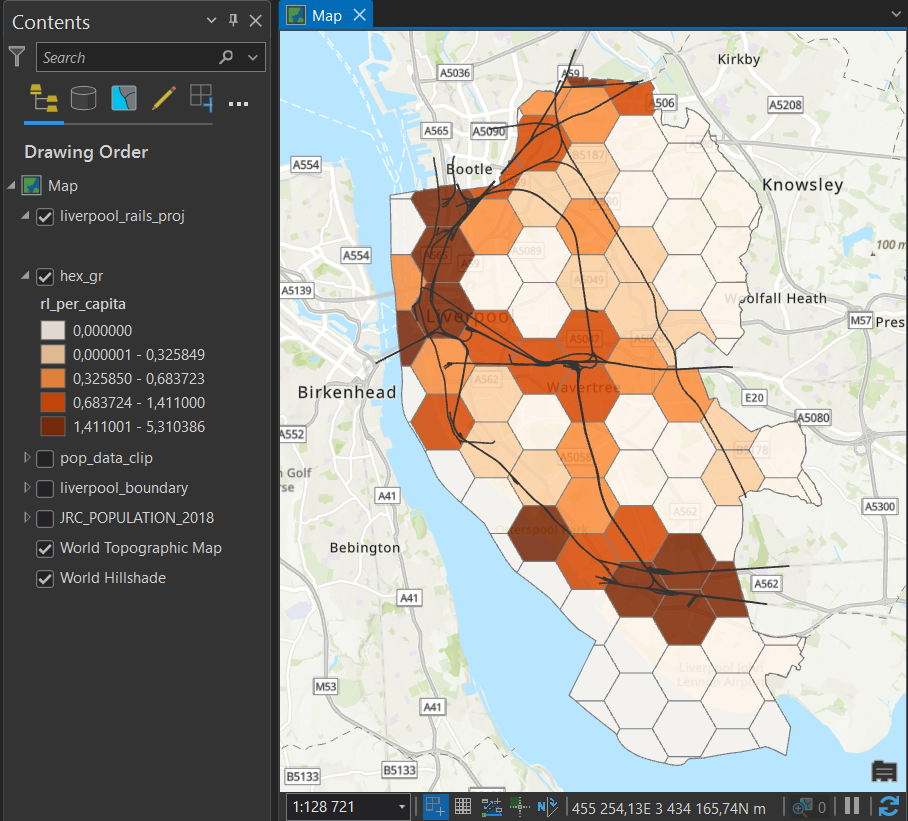